<p align="center">
    <img src="https://github.com/GeostatsGuy/GeostatsPy/blob/master/TCG_color_logo.png?raw=true" width="220" height="240" />

</p>

## PGE 383 Graduate Student Project Template and Intructions 

#### Michael J Pyrcz, Professor, The University of Texas at Austin 

##### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Geostatistics Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [Applied Geostats in Python e-book](https://geostatsguy.github.io/GeostatsPyDemos_Book/intro.html) | [Applied Machine Learning in Python e-book](https://geostatsguy.github.io/MachineLearningDemos_Book/) | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)


## Gaussian Mixture Model (GMM) Clustering

#### Ali Oshaish
#### Hildebrancd Department of Petroleum and Geosystems Engineering, Cockrell School of Engineering

### Subsurface Machine Learning Course, The University of Texas at Austin
#### Hildebrand Department of Petroleum and Geosystems Engineering, Cockrell School of Engineering
#### Department of Geological Sciences, Jackson School of Geosciences

_____________________

Workflow supervision and review by:

#### Instructor: Prof. Michael Pyrcz, Ph.D., P.Eng., Associate Professor, The Univeristy of Texas at Austin
[Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Geostatistics Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [Applied Geostats in Python e-book](https://geostatsguy.github.io/GeostatsPyDemos_Book/intro.html) | [Applied Machine Learning in Python e-book](https://geostatsguy.github.io/MachineLearningDemos_Book/) | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Course TA: Elnara Rustamzade, Graduate Student, The University of Texas at Austin
##### [LinkedIn](https://www.linkedin.com/in/elnara-rustamzade/)


### Executive Summary

Clustering complex and irregularly shaped data remains a significant challenge in unsupervised machine learning. In our project, we explored clustering a unique dataset that is non-spherical, non-convex, and anisotropic, with distinctive patterns that form clear clusters. Some widely used clustering techniques failed to detect these clusters accurately:

* K-Means clustering produced inaccurate groupings, even when the correct number of clusters was specified.

* DBSCAN resulted in excessive noise despite parameter tuning, rendering a significant portion of the data as outliers.

To overcome these limitations, we applied Gaussian Mixture Model (GMM) clustering, which uses a probabilistic, soft-clustering approach based on the Expectation-Maximization algorithm. Model selection was optimized using:

* Akaike Information Criterion (AIC)

* Bayesian Information Criterion (BIC)

This tuning process helped to balance model fit with complexity. The GMM method successfully identified meaningful clusters that aligned well with the data structure, outperforming the previous techniques.

### Import Packages
The following code block is from Professor Michael Pyrcz (@GeostatsGuy), SubSurfuceDataAnalytics_PCA.ipynb from GeostatsGuy GitHub.


In [121]:
import os  # Set working directory, run executables                                                     # to set current working directory 
import geostatspy.GSLIB as GSLIB  # GSLIB utilities, visualization, and wrapper
import geostatspy.geostats as geostats  # GSLIB methods converted to Python  
import numpy as np  # Arrays for gridded data
import pandas as pd  # DataFrames for tabular data
import matplotlib.pyplot as plt  # Plotting
from kneed import KneeLocator   # For obtaining the elbow in the AIC and BIC curves plots to optimize K
import copy  # Deep copies
from sklearn.mixture import GaussianMixture  # GMM Clustering
from sklearn.preprocessing import MinMaxScaler # min/max normalization
from matplotlib.patches import Ellipse     # Plotting ellipses
import warnings
from tabulate import tabulate

### Functions
We define one function here to optimize the plotting by drawing an ellipse that contains each cluster.

In [122]:
# Function to draw ellipses
def draw_ellipse(position, covariance, ax, **kwargs):
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(xy=position, width=nsig * width, height=nsig * height, angle=angle, **kwargs))

### Theoretical Background of (GMM) Clustering:

In this analysis, clustering is performed using a **Gaussian Mixture Model (GMM)**, a probabilistic method that assumes the data is generated from a mixture of multiple Gaussian distributions (McLachlan & Peel, 2000; Bishop, 2006). Each cluster $k$ is represented by a multivariate normal distribution defined by a mean vector $\mu_k$ and a covariance matrix $\Sigma_k$. The probability density function for a data point $\mathbf{x}$ in cluster $k$ is given by:

\\[
p(\mathbf{x} \mid \mu_k, \Sigma_k) = \frac{1}{(2\pi)^{d/2} |\Sigma_k|^{1/2}} \exp\left( -\frac{1}{2} (\mathbf{x} - \mu_k)^T \Sigma_k^{-1} (\mathbf{x} - \mu_k) \right)
\\]

The overall likelihood of a data point is modeled as a weighted sum of all Gaussian components:

\\[
p(\mathbf{x}) = \sum_{k=1}^{K} \pi_k \cdot p(\mathbf{x} \mid \mu_k, \Sigma_k)
\\]

Here, $\pi_k$ is the mixing coefficient (prior probability) for cluster $k$, subject to the constraint $\sum_{k=1}^{K} \pi_k = 1$. The model parameters $\pi_k$, $\mu_k$, and $\Sigma_k$ are estimated using the **Expectation-Maximization (EM)** algorithm (Dempster et al., 1977), which maximizes the likelihood of the observed data.

To determine the optimal number of clusters $K$, two widely-used information criteria are employed:

1. **Akaike Information Criterion (AIC) (Akaike, 1974)**:
\\[
\text{AIC} = 2p - 2\ln(L)
\\]

2. **Bayesian Information Criterion (BIC) (Schwarz, 1978)**:
\\[
\text{BIC} = p \cdot \ln(n) - 2\ln(L)
\\]

Here, $p$ is the number of model parameters, $n$ is the number of data points, and $L$ is the maximized likelihood of the model. Both AIC and BIC provide a balance between model complexity and fit, with lower values indicating a better model. BIC applies a stronger penalty for complexity, making it more conservative in selecting the number of clusters.

###  References

- Akaike, H. (1974). A new look at the statistical model identification. IEEE transactions on automatic control, 19(6), 716-723.‏
- Bishop, C. M., & Nasrabadi, N. M. (2006). Pattern recognition and machine learning (Vol. 4, No. 4, p. 738). New York: springer.‏
- Dempster, A. P., Laird, N. M., & Rubin, D. B. (1977). Maximum likelihood from incomplete data via the EM algorithm. Journal of the royal statistical society: series B (methodological), 39(1), 1-22.‏
- Schwarz, G. (1978). Estimating the dimension of a model. The annals of statistics, 461-464.‏
```

### Illustrating the GMM Concept Using Synthetic Dataset

Below is an illustration of the Gaussian Mixture Model (GMM) clustering using synthetic data. The code for illustrating the contours was obtained from the book: Bishop, C. M. (2006), Pattern Recognition and Machine Learning. The ellipsoidal contours represent the multivariate Gaussian distributions learned by the model, and each data point is color-coded according to its assigned cluster. This visualization helps in understanding how GMM models the data as a mixture of Gaussian distributions. 

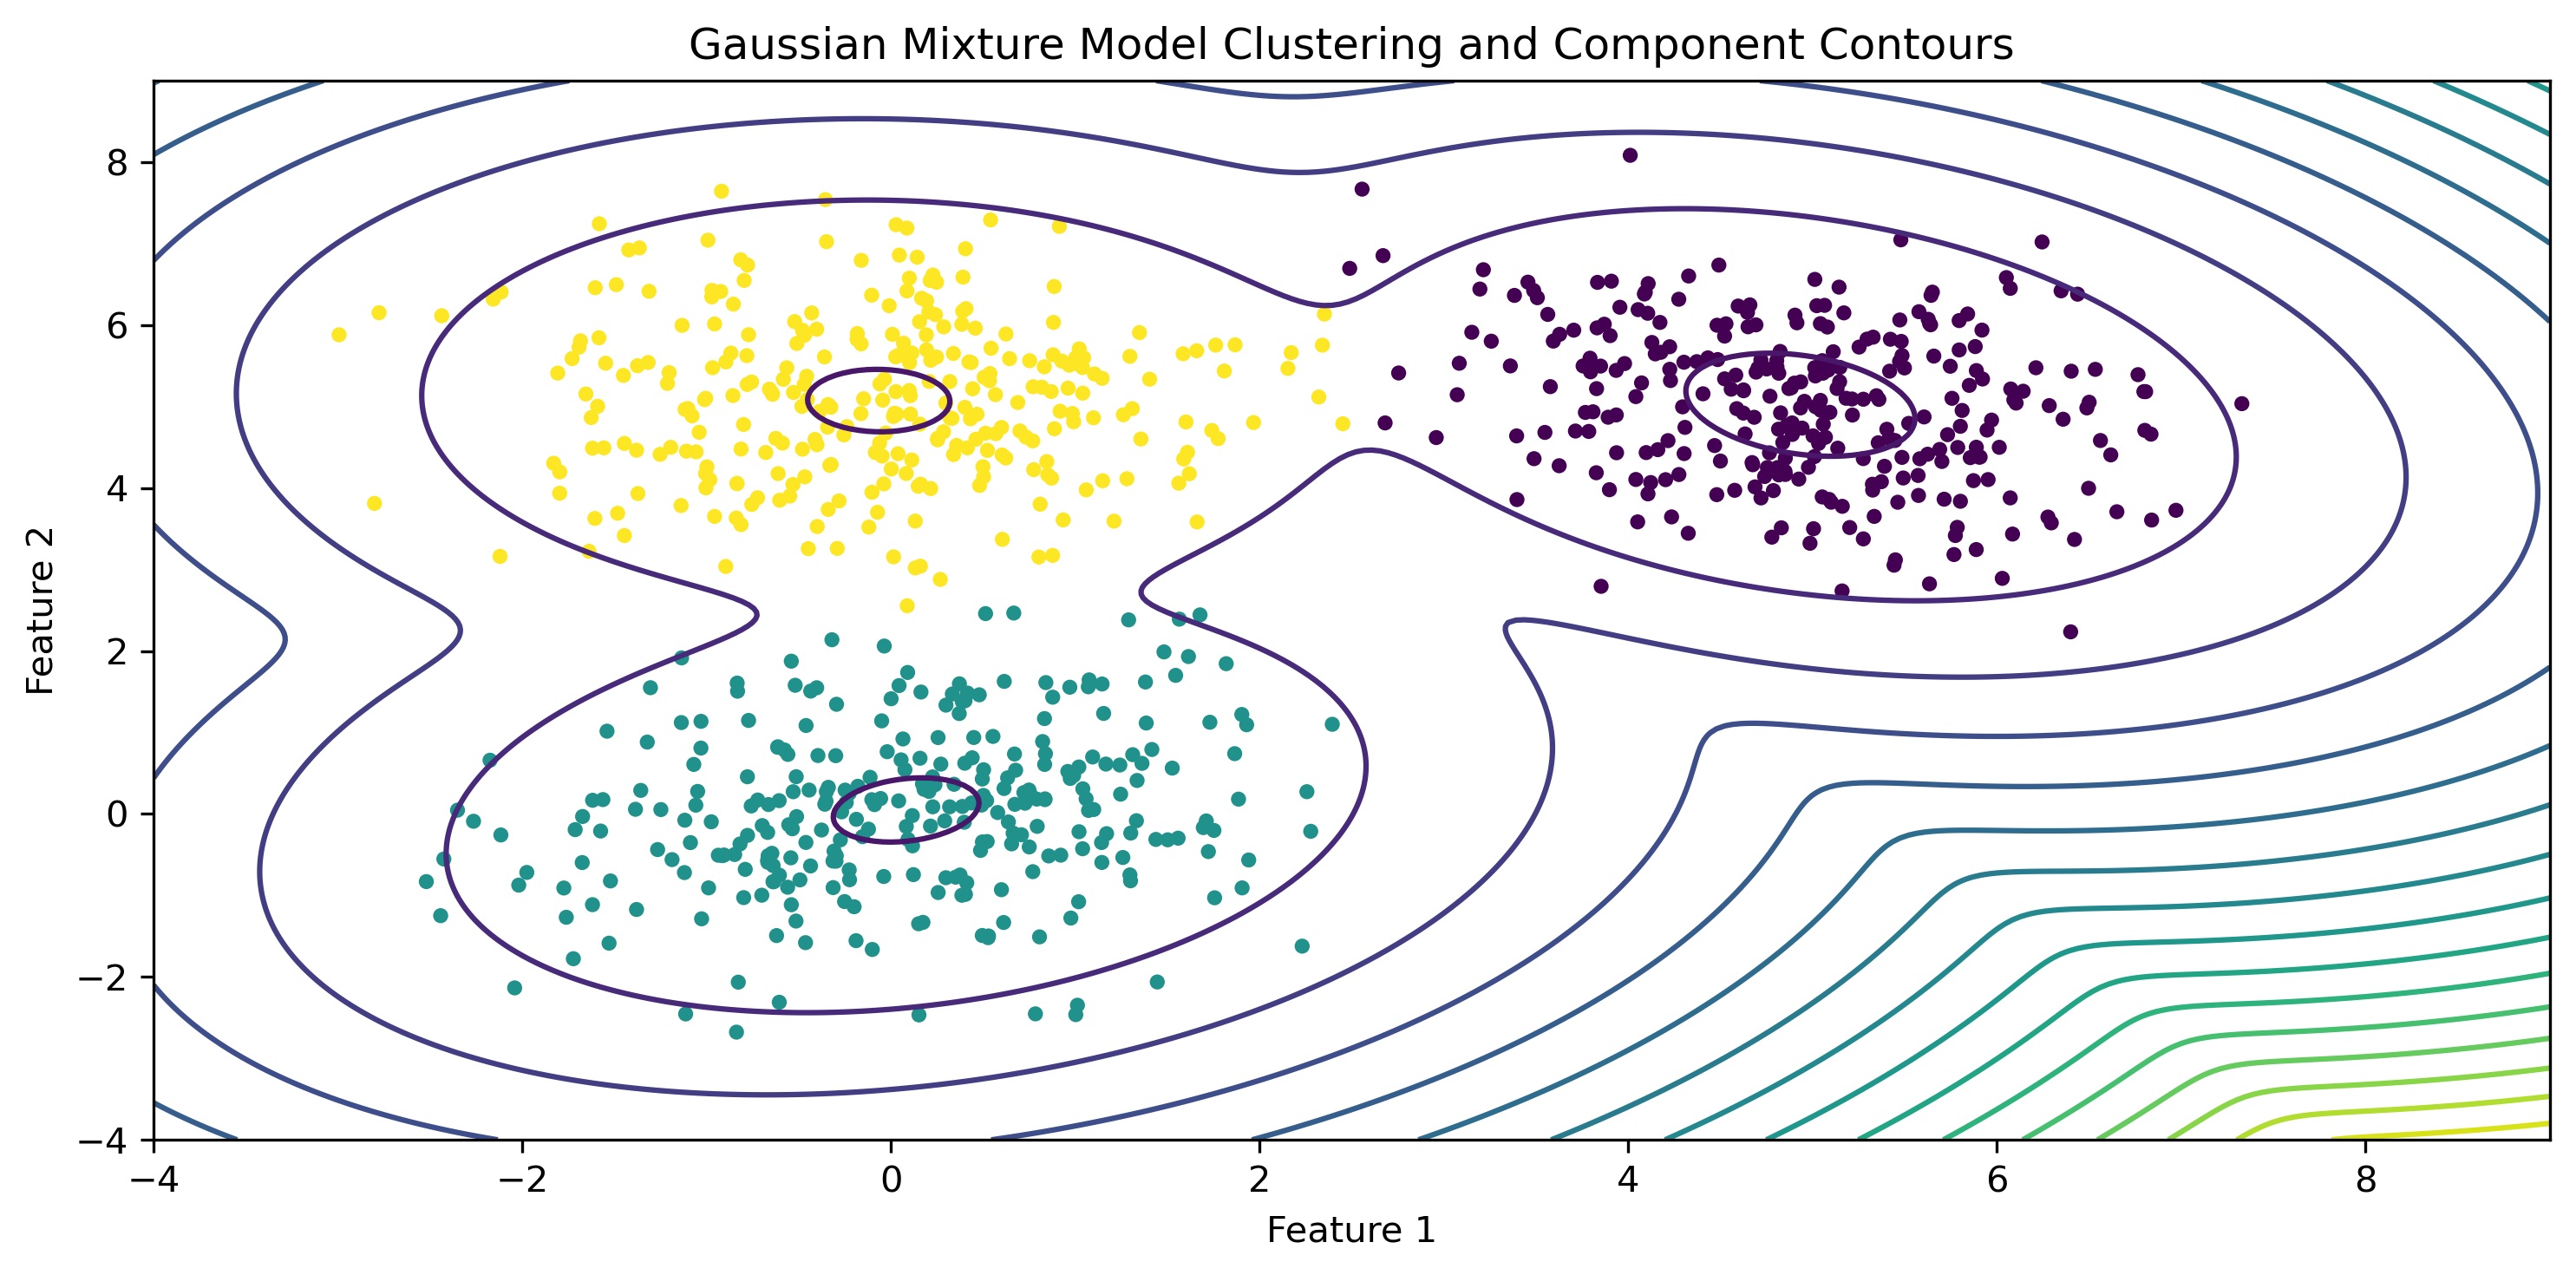

In [123]:
np.random.seed(0) # Generate synthetic data
n_samples = 300   # number of data points to be generated.

mean1 = [0, 0]                    # Mean of the 1st cluster within the dataset generated
cov1 = [[1.0, 0.2], [0.2, 1.0]]   # Covariance Matrix of the data points in the 1st cluster.
mean2 = [5, 5]                    # Mean of the 2nd cluster within the dataset generated
cov2 = [[1.0, -0.3], [-0.3, 1.0]] # Covariance Matrix of the data points in the 2nd cluster.
mean3 = [0, 5]                    # Mean of the 3rd cluster within the dataset generated
cov3 = [[1.0, 0.0], [0.0, 1.0]]   # Covariance Matrix of the data points in the 3rd cluster.

# Generating the data points for the 3 clusters using normal distribution
data1 = np.random.multivariate_normal(mean1, cov1, n_samples)  
data2 = np.random.multivariate_normal(mean2, cov2, n_samples)
data3 = np.random.multivariate_normal(mean3, cov3, n_samples)
X = np.vstack((data1, data2, data3))       # Combining the 3 clusters to form one dataset

gmm = GaussianMixture(n_components=3, covariance_type='full') # Fitting GMM for the dataset created.
gmm.fit(X)
labels = gmm.predict(X)

# Plotting the datasets in clusters and drawing the ellipsoidal contours to represent the multivariate Gaussian distributions
x = np.linspace(-4, 9, 300)
y = np.linspace(-4, 9, 300)
X_grid, Y_grid = np.meshgrid(x, y)
XX = np.array([X_grid.ravel(), Y_grid.ravel()]).T
Z = -gmm.score_samples(XX)
Z = Z.reshape(X_grid.shape)

fig, ax = plt.subplots(figsize=(10, 5), dpi=300)
ax.scatter(X[:, 0], X[:, 1], c=labels, s=10, cmap='viridis', label="Data Points")
ax.contour(X_grid, Y_grid, Z, levels=15, linewidths=1.5)

ax.set_title('Gaussian Mixture Model Clustering and Component Contours')
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
plt.tight_layout()
plt.show()

### Load Data

The following workflow applies to the .csv file 'nonlinear_facies_v2.csv', a synthetic dataset available on the GeostatsGuy GetHub: https://raw.githubusercontent.com/GeostatsGuy/GeoDataSets.

We will work with the following features:

* **Acoustic Impedance (AI)** - a property of the rock that describes how much resistance it offers to the passage of sound waves in $kg/m^2s$
* **porosity (Por)** - fraction of rock void in units of percentage.
* **Facies** - pre-determined lithification indicator based on geological and petrophysical analysis. This feature will not be used during the clustering. It will be used only for comparison at the end; to assess the clustering performance.



In [124]:
df = pd.read_csv("https://raw.githubusercontent.com/GeostatsGuy/GeoDataSets/master/nonlinear_facies_v2.csv") # load the comma delimited data file from Dr. Pyrcz's GeoDataSets GitHub repository
col = ['AI', 'Por', 'Facies']  # Assign each column of the loaded data to a particular feature.
df = df[col]    # Build the data frame which consists of the columns in our work.

### 1. Normalizing the features and calculating the summary statistics

The following workflow applies a normal transform on the porosity and Acoustic Impedance features to be used in GMM clustering, and shows the summary statistics of the original and transformed features.

In [125]:
# Normalize features
transform = MinMaxScaler()
df['nAI'] = transform.fit_transform(df[['AI', 'Por']])[:, 0]
df['nPor'] = transform.fit_transform(df[['AI', 'Por']])[:, 1]
df.describe().transpose()                                     # calculate summary statistics for the data

,count,mean,std,min,25%,50%,75%,max
AI,1800.0,625.522917,247.547997,10.0,518.076017,683.865824,783.315226,1200.0
Por,1800.0,17.122778,4.778704,0.0,14.663434,17.674606,20.361860,30.0
Facies,1800.0,1.666667,0.816723,1.0,1.000000,1.000000,2.000000,3.0
nAI,1800.0,0.517246,0.208024,0.0,0.426955,0.566274,0.649845,1.0
nPor,1800.0,0.570759,0.159290,0.0,0.488781,0.589154,0.678729,1.0


### 2. The optimization of number of clusters (k)

The following workflow applies the GMM on the normalized features over wide range of (k). To evaluate the performance of GMM for each k value, AIC and BIC scores are calculated and plotted against the k values.

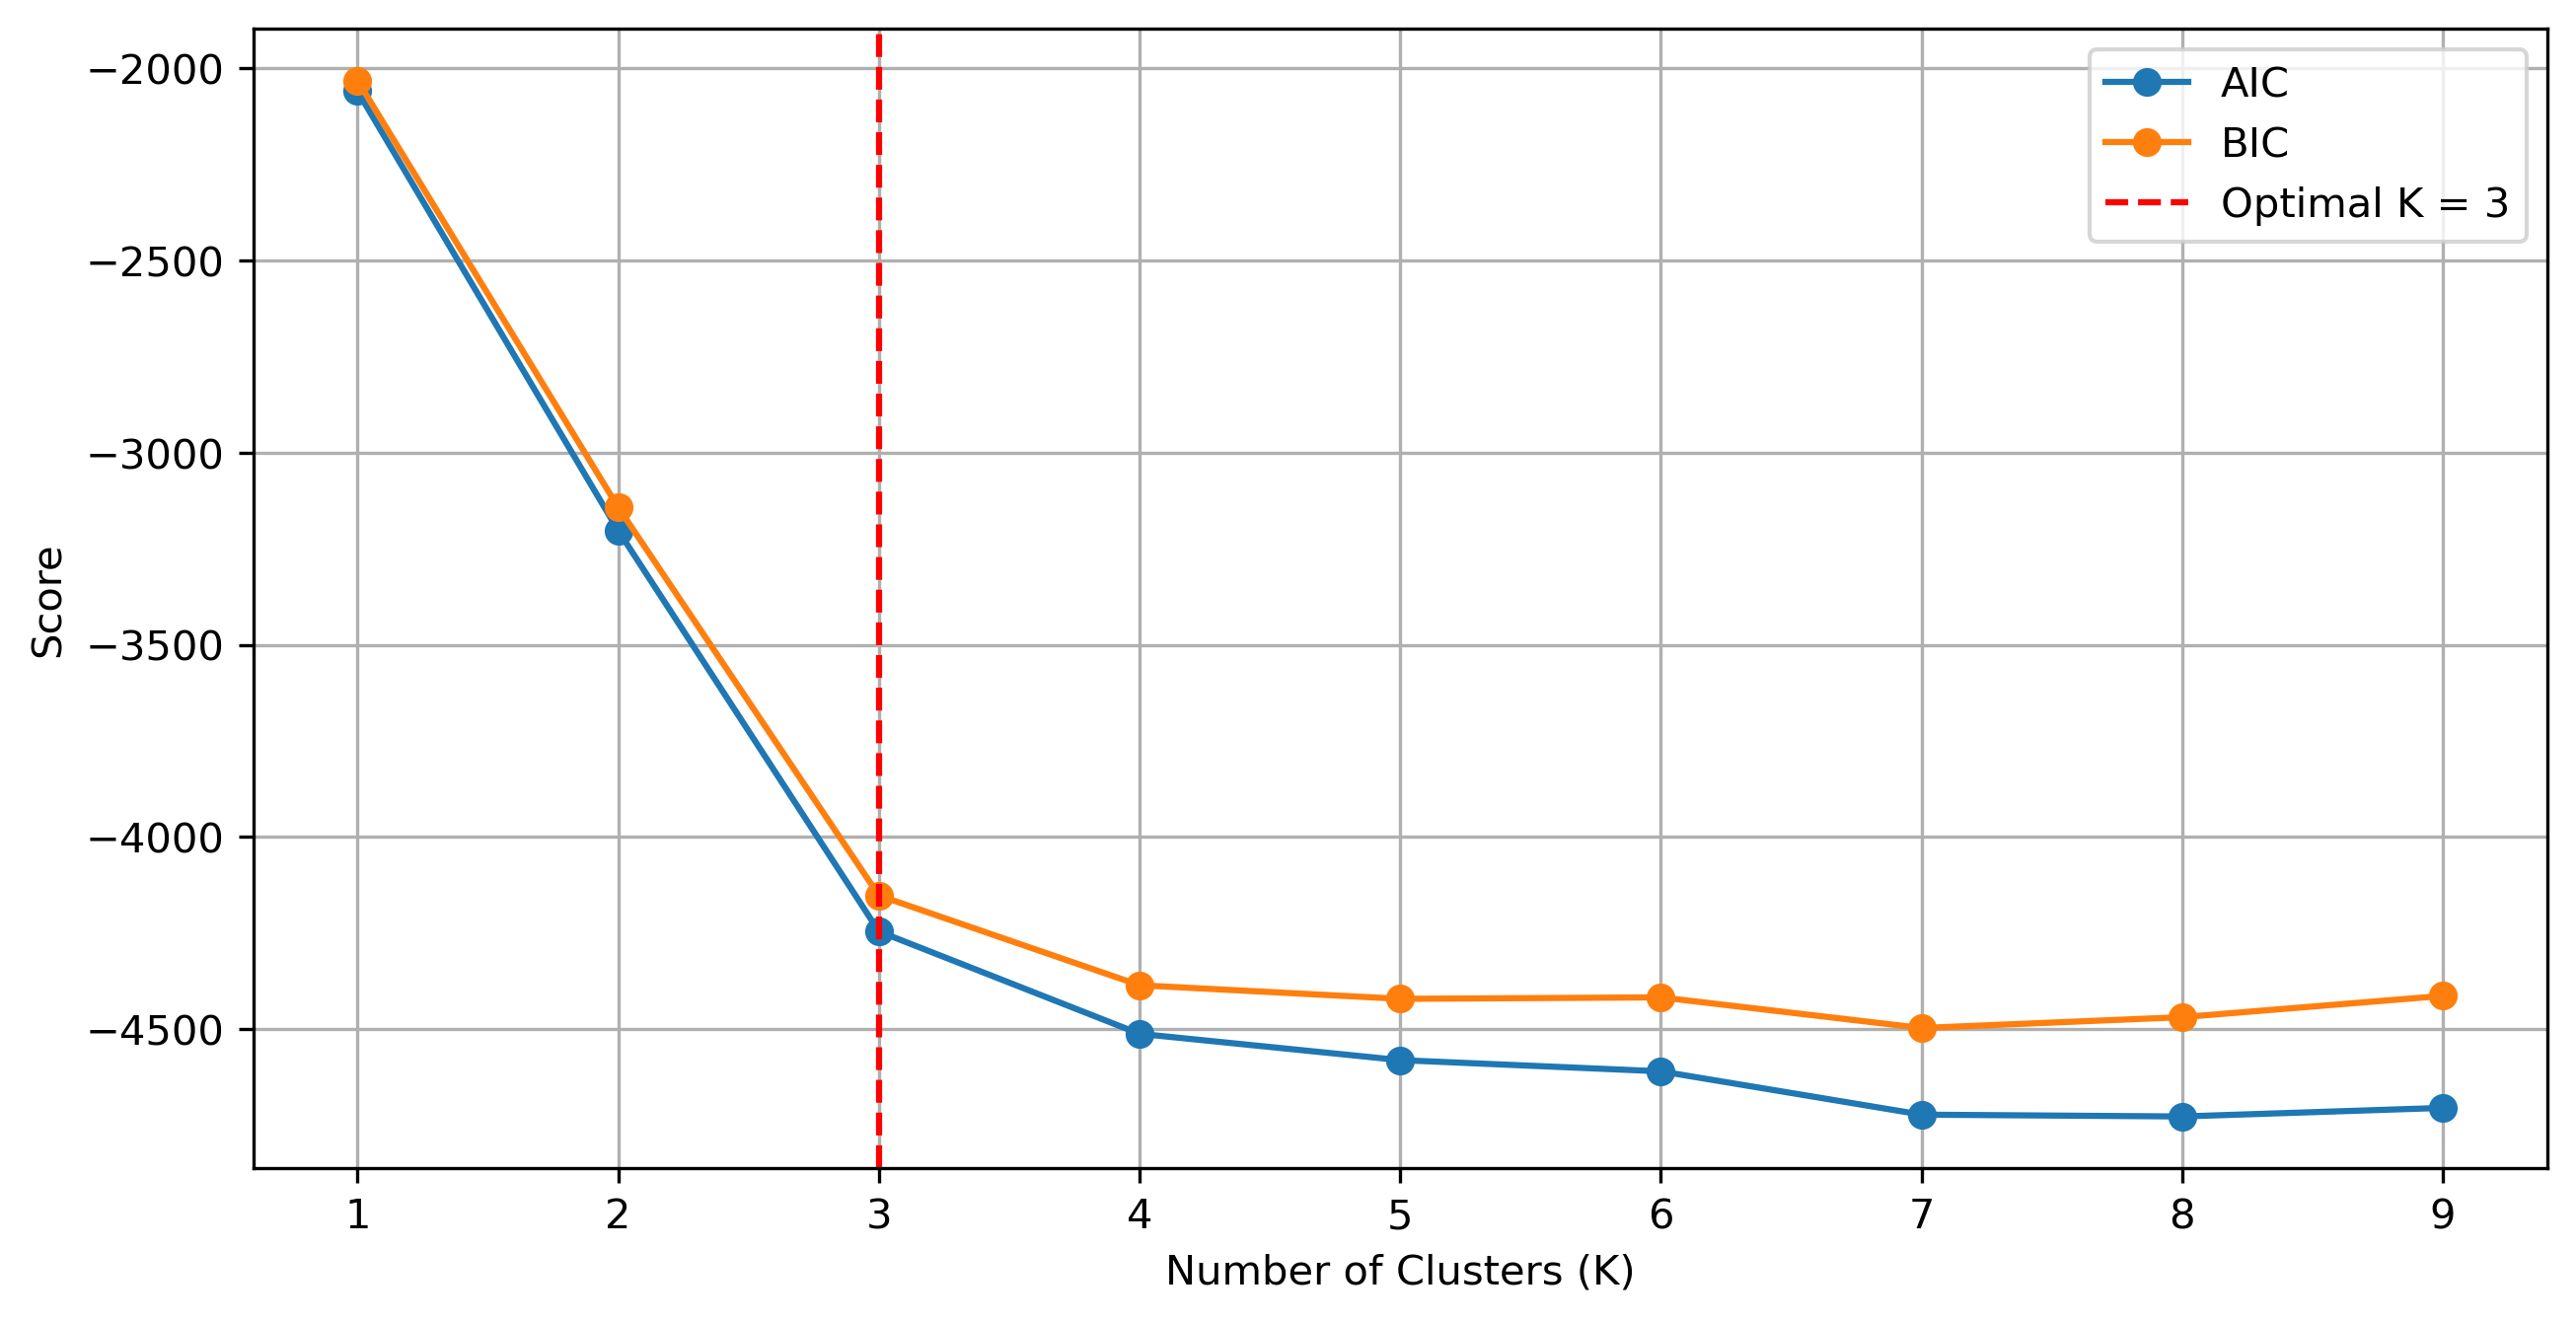

In [126]:
K_values = range(1, 10)      # Range of K values to be investigated.
aic_scores = []              # Initializing AIC score. 
bic_scores = []              # Initializing BIC score. 

for K in K_values:           # Looping over K_values.
    gmm = GaussianMixture(n_components=K, random_state=42, covariance_type='full') # Generating K Gausian Mixtures distributions.
    gmm.fit(df[['nAI', 'nPor']])     # Fitting the distributions over the features of interest.
    aic_scores.append(gmm.aic(df[['nAI', 'nPor']]))     # Calculating AIC score.
    bic_scores.append(gmm.bic(df[['nAI', 'nPor']]))     # Calculating BIC score.
knee_locator = KneeLocator(K_values, bic_scores, curve="convex", direction="decreasing")   # Locating the elbow of the BIC scores.
optimal_K = knee_locator.elbow    # Equalizing the optimal number of clusters (optimal_K) to the elbow value of the BIC scores.
# Plot AIC/BIC
fig1 = plt.figure(figsize=(10, 5), dpi=300)
plt.plot(K_values, aic_scores, label="AIC", marker='o')
plt.plot(K_values, bic_scores, label="BIC", marker='o')
plt.axvline(x=optimal_K, color='r', linestyle="--", label=f"Optimal K = {optimal_K}")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Score")
plt.legend()
plt.grid()
plt.show()


### 

The optimum number of clusters was obtained automatically using the knee locator function, which detects the elbow in the plotted curve. As the plot shows, the elbow value of the BIC curve corresponding to optimal_K was selected correctly (optimal_K = 3).

### 3. Fitting the GMM using the optimized K (Optimal_K)

The following workflow will apply the GMM over the dataset using the optimal_K value evaluated in the previous workflow. To visualize the appropriateness of clustering, two mini-plots will be generated for the clustered data points. The first plot shows the clusters using the original features, while the second plot visualizes the clusters using the normalized features. To benchmark each created cluster to the corresponding facies class, we remap the clusters' labels to match the corresponding facies. For example, cluster 1 should be associated with facies 1 and so on. To show the proportion of each cluster, a histogram of the clusters is shown in the last plot.

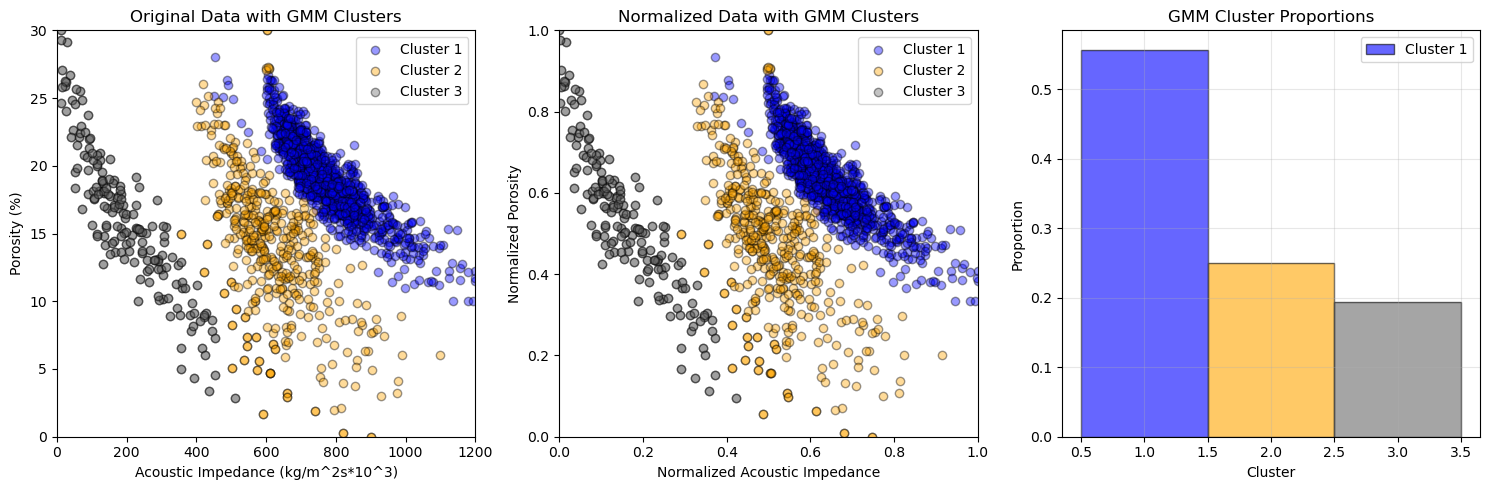

In [127]:
gmm = GaussianMixture(n_components=optimal_K, random_state=42, covariance_type='full') # Generating K Gausian Mixtures distributions.
df['GMM_raw'] = gmm.fit_predict(df[['nAI', 'nPor']]) + 1             # Fitting the distributions over the features of interest.

mapping = {1: 1, 2: 3, 3: 2}  # Remap GMM cluster labels to match True Facies (GMM Cluster Label = True Facies)
df['GMM'] = df['GMM_raw'].map(mapping)

cluster_colors = {
    1: 'blue',       # Facies 1
    2: 'orange',     # Facies 2
    3: 'dimgray'     # Facies 3
}                            # Assigning colors for each cluster/facies.

xlabel = 'Acoustic Impedance (kg/m^2s*10^3)'
ylabel = 'Porosity (%)'
xlabel_Norm = 'Normalized Acoustic Impedance'
ylabel_Norm = 'Normalized Porosity'

fig2 = plt.figure(figsize=(15, 5))      # Estintiating the the figure

plt.subplot(131)
for cluster_id in sorted(df['GMM'].unique()):
    cluster_points = df[df['GMM'] == cluster_id]
    plt.scatter(cluster_points['AI'], cluster_points['Por'], alpha=0.4, edgecolors="black", label=f'Cluster {cluster_id}', color=cluster_colors[cluster_id])
plt.title('Original Data with GMM Clusters')
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.xlim(0, 1200)
plt.ylim(0, 30)
plt.legend()

plt.subplot(132)
for cluster_id in sorted(df['GMM'].unique()):
    cluster_points = df[df['GMM'] == cluster_id]
    plt.scatter(cluster_points['nAI'], cluster_points['nPor'], alpha=0.4, edgecolors="black", label=f'Cluster {cluster_id}', color=cluster_colors[cluster_id])
plt.title('Normalized Data with GMM Clusters')
plt.xlabel(xlabel_Norm)
plt.ylabel(ylabel_Norm)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.legend()

plt.subplot(133)
counts, bins, patches = plt.hist(df['GMM'], bins=np.arange(0.5, optimal_K + 1.5, 1), edgecolor="black", alpha=0.6, density=True)
for patch, cluster_id in zip(patches, sorted(df['GMM'].unique())):
    patch.set_facecolor(cluster_colors[cluster_id])
plt.title('GMM Cluster Proportions')
plt.xlabel('Cluster')
plt.ylabel("Proportion")
plt.grid(alpha=0.3)
plt.legend([f"Cluster {i}" for i in sorted(df['GMM'].unique())])

plt.tight_layout()
fig2.savefig("GMM_Clustering_Results.png", dpi=300, bbox_inches='tight')
plt.show()


### 4. Improving the explainability of the GMM clustering

The following workflow generates a descriptive plot that provides a clear and informative visualization of the Gaussian Mixture Model clustering results applied to the normalized Acoustic Impedance and Porosity data. The added ellipses represent the Gaussian components (clusters) learned by the model:

 - The shape and orientation of each ellipse are derived from the covariance matrix of the corresponding Gaussian distribution.
 - Each ellipse shows 1σ to 3σ confidence regions, giving insight into cluster spread and uncertainty.

This enhanced plot helps:

 - Visually assess the fit and separation of GMM clusters.
 - Understand the spread and orientation of each Gaussian component.
 - Identify potential overlaps or misclassifications based on how ellipses interact.

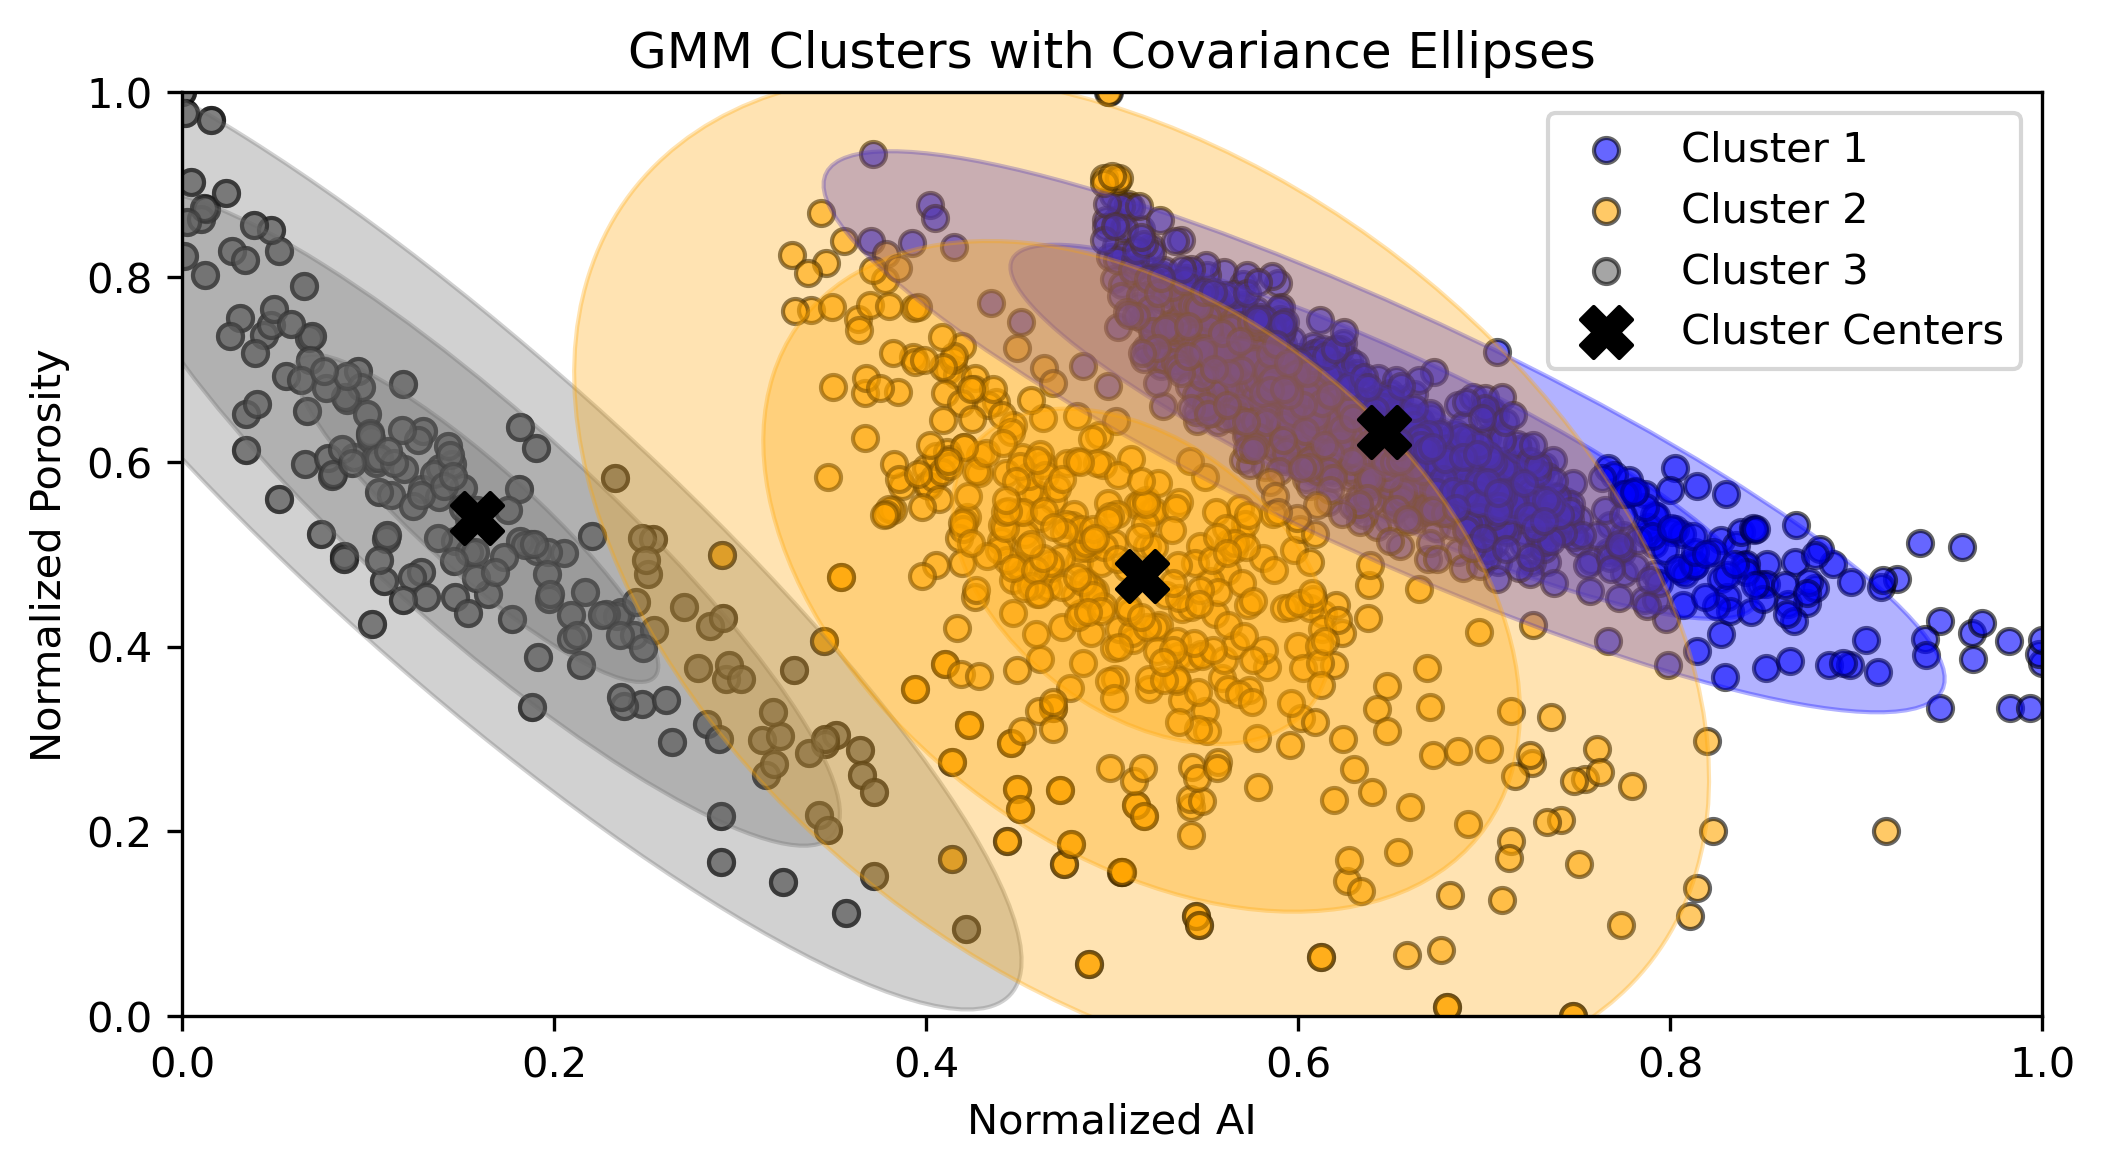

In [128]:
fig3, ax = plt.subplots(figsize=(8, 4), dpi=300)        # Estintiating the enhanced Plot with Ellipses
for cluster_id in sorted(df['GMM'].unique()):
    cluster_points = df[df['GMM'] == cluster_id]
    ax.scatter(cluster_points['nAI'], cluster_points['nPor'], label=f'Cluster {cluster_id}', alpha=0.6, edgecolor='k', color=cluster_colors[cluster_id])

ax.set_title("GMM Clusters with Covariance Ellipses")
ax.set_xlabel('Normalized AI')
ax.set_ylabel('Normalized Porosity')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

for i, (mean, covar) in enumerate(zip(gmm.means_, gmm.covariances_)):                # Pulling the mean and covariance values of the GMM clusters.
    cluster_label = mapping[i + 1]                                                   # Match remapped cluster ID
    draw_ellipse(mean, covar, ax, alpha=0.3, color=cluster_colors[cluster_label])    # Draw the ellipses using the cluster_colors

ax.scatter(gmm.means_[:, 0], gmm.means_[:, 1], s=150, c='black', marker='X', label='Cluster Centers')
ax.legend()
fig3.savefig("GMM_Cluster_Ellipses.png", dpi=600, bbox_inches='tight')
plt.show()

### 5. Results summary of the GMM clustering

The following workflow provides an overview of the performance of the GMM clustering through the following:

 - Calculate the summary statistics of the clusters resulted from GMM.
 - Calculate and visualize the uncertainty in the GMM results using a matrix that shows the counts and percentages of truly and falsely classified data points. In other words, we calculate the goodness metric of the GMM results by considering it as a classification problem concerning the original facies.

To construct the confusion matrix, we use "pd.crosstab" which is a pandas function used to compute a cross-tabulation (contingency table) of two or more series. It shows the frequency (counts) of occurrences for combinations of categories in two columns.
 




Clusters Summary Statistics:
     Cluster  Por-Mean  Por-P10  Por-P50  Por-P90  AI-Mean  AI-P10  AI-P50  \
0  Cluster 1     19.01    15.16    19.05    22.76   776.63  649.95  756.52   
1  Cluster 2     13.76     6.48    14.15    20.36   616.31  483.59  599.84   
2  Cluster 3     16.03     9.00    15.56    22.95   202.36   55.76  183.14   

   AI-P90  Count  
0  941.43   1002  
1  769.63    450  
2  383.48    348  

Facies vs GMM Crosstab:
GMM Cluster    1    2    3
True Facies               
1            984   16    0
2             18  382    0
3              0   52  348


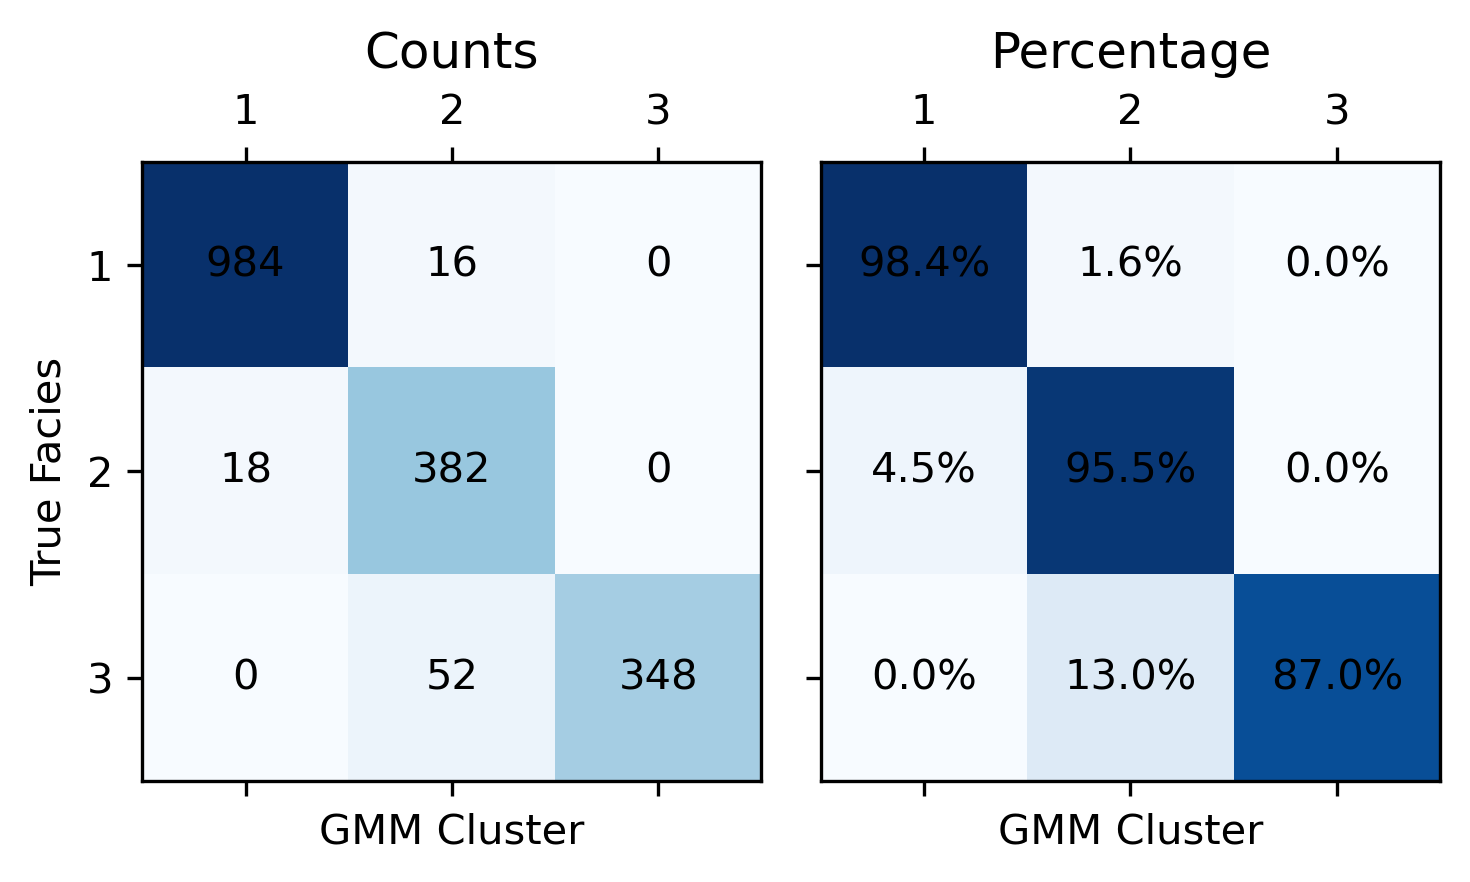

In [129]:
summary = []                              # Calculating the summary statistics per cluster
for i in sorted(df['GMM'].unique()):
    cluster_data = df[df['GMM'] == i]
    AI_vals = cluster_data['AI']
    Por_vals = cluster_data['Por']
    summary.append([
        f"Cluster {i}",
        round(Por_vals.mean(), 2), round(np.percentile(Por_vals, 10), 2), round(np.percentile(Por_vals, 50), 2), round(np.percentile(Por_vals, 90), 2),
        round(AI_vals.mean(), 2), round(np.percentile(AI_vals, 10), 2), round(np.percentile(AI_vals, 50), 2), round(np.percentile(AI_vals, 90), 2),
        len(cluster_data)
    ])
    
# Formatting the matrix used to display summary statistics per cluster
headers = ['Cluster', 'Por-Mean', 'Por-P10', 'Por-P50', 'Por-P90', 'AI-Mean', 'AI-P10', 'AI-P50', 'AI-P90', 'Count'] 
summary_df = pd.DataFrame(summary, columns=headers)
summary_df.to_csv("GMM_cluster_summary.csv", index=False)
print("\nClusters Summary Statistics:")
print(summary_df)


crosstab = pd.crosstab(df['Facies'], df['GMM'], rownames=['True Facies'], colnames=['GMM Cluster']) 
# Computing the elements of the confusion matrix using the counts. 
crosstab_percent = crosstab.div(crosstab.sum(axis=1), axis=0) * 100 # Computing the elements of the confusion matrix using the percentages relative to number of data.
print("\nFacies vs GMM Crosstab:")
print(crosstab)


fig, axes = plt.subplots(ncols=2, figsize=(5, 3), dpi=300) # Creating the figure to show the confusion matrices heatmaps.

# Heatmap 1: Count-Based Confusion Matrix
ax1 = axes[0]
im1 = ax1.matshow(crosstab.values, cmap='Blues')
for (i, j), val in np.ndenumerate(crosstab.values):
    ax1.text(j, i, str(val), va='center', ha='center', color='black')
ax1.set_xticks(np.arange(crosstab.shape[1]))
ax1.set_yticks(np.arange(crosstab.shape[0]))
ax1.set_xticklabels(crosstab.columns)
ax1.set_yticklabels(crosstab.index)
ax1.set_title("Counts")
ax1.set_xlabel("GMM Cluster")
ax1.set_ylabel("True Facies")

# Heatmap 2: Percentage-Based Confusion Matrix
ax2 = axes[1]
im2 = ax2.matshow(crosstab_percent.values, cmap='Blues')
for (i, j), val in np.ndenumerate(crosstab_percent.values):
    ax2.text(j, i, f"{val:.1f}%", va='center', ha='center', color='black')
ax2.set_xticks(np.arange(crosstab.shape[1]))
ax2.set_yticks(np.arange(crosstab.shape[0]))
ax2.set_xticklabels(crosstab.columns)
ax2.set_yticklabels([])  # Remove to avoid duplicate labels
ax2.set_title("Percentage")
ax2.set_xlabel("GMM Cluster")

plt.tight_layout()
plt.show()

### 6. Results discussion and concluding remarks

The GMM clustering shows an excellent performance in detecting the scattering pattern of the unique dataset used. It worked well in incorporating the non-linearity and anisotropy in the relationship between porosity and AI. The performance was evaluated by comparing predicted cluster labels to true facies classifications. The confusion matrix derived from the final mapping is as follows:

| **True Facies** | **GMM Cluster 1** | **GMM Cluster 2** | **GMM Cluster 3** |
|-----------------|------------------|------------------|------------------|
| **Facies 1**    | 984              | 16               | 0                |
| **Facies 2**    | 18               | 382              | 0                |
| **Facies 3**    | 0                | 52               | 348              |

Using this matrix, we compute the following performance metrics:

#### Facies 1:
- **Precision** = 984 / (984 + 18) = **0.9820**
- **Recall** = 984 / (984 + 16) = **0.9840**
- **F1-score** = 2 × (0.9820 × 0.9840) / (0.9820 + 0.9840) = **0.9830**

#### Facies 2:
- **Precision** = 382 / (382 + 68) = **0.8489**
- **Recall** = 382 / (382 + 18) = **0.9550**
- **F1-score** = 2 × (0.8489 × 0.9550) / (0.8489 + 0.9550) = **0.8988**

#### Facies 3:
- **Precision** = 348 / (348 + 0) = **1.0000**
- **Recall** = 348 / (348 + 52) = **0.8709**
- **F1-score** = 2 × (1.0000 × 0.8709) / (1.0000 + 0.8709) = **0.9305**

These results demonstrate excellent clustering performance, especially for Facies 1 and 3, with Facies 2 also showing strong alignment despite some misclassification. Overall, the GMM model shows high precision and recall consistency across classes.

### About the student authoring this code:

Ali Oshaish is a PhD student in the [Hildebrand Department of Petroleum and Geosystems Engineering](https://www.pge.utexas.edu/), at [The University of Texas at Austin](https://www.utexas.edu/), where his research focuses on enhancing the petrophysical characterization of unconventional reservoirs and modeling the flow dynamics during Huff and Puff EOR processes. He is a member of the petrophysics and EOR research groups led by professors Zoya Heidari and Kishore Mohanty.

Ali has around 11 years of field experience in the oil and gas industry, working in the Formation Evaluation and Surface Production and Completion Systems areas. He has a total of 13 papers that were published in [industry-known conferences and peer-reviewed journals](https://scholar.google.com/citations?user=Mj67dT8AAAAJ). His vision is to bridge the field's hands-on experience with top-class knowledge received in the world's top petroleum engineering institution to cultivate cutting-edge research that can resolve different challenges facing the energy sector. 

Ali will be excited for internship or work opportunities in the energy sector and will strive hard to bring impactful contributions to the advancement of sustainable energy technologies and subsurface resource development through innovative research and practical field applications. 



#### About the Supervising Professor

Michael Pyrcz is a professor in the [Cockrell School of Engineering](https://cockrell.utexas.edu/faculty-directory/alphabetical/p), and the [Jackson School of Geosciences](https://www.jsg.utexas.edu/researcher/michael_pyrcz/), at [The University of Texas at Austin](https://www.utexas.edu/), where he researches and teaches subsurface, spatial data analytics, geostatistics, and machine learning. Michael is also,

* the principal investigator of the [Energy Analytics](https://fri.cns.utexas.edu/energy-analytics) freshmen research initiative and a core faculty in the Machine Learn Laboratory in the College of Natural Sciences, The University of Texas at Austin

* an associate editor for [Computers and Geosciences](https://www.sciencedirect.com/journal/computers-and-geosciences/about/editorial-board), and a board member for [Mathematical Geosciences](https://link.springer.com/journal/11004/editorial-board), the International Association for Mathematical Geosciences. 

Michael has written over 70 [peer-reviewed publications](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en), a [Python package](https://pypi.org/project/geostatspy/) for spatial data analytics, co-authored a textbook on spatial data analytics, [Geostatistical Reservoir Modeling](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) and author of two recently released e-books, [Applied Geostatistics in Python: a Hands-on Guide with GeostatsPy](https://geostatsguy.github.io/GeostatsPyDemos_Book/intro.html) and [Applied Machine Learning in Python: a Hands-on Guide with Code](https://geostatsguy.github.io/MachineLearningDemos_Book/intro.html).

All of Michael’s university lectures are available on his [YouTube Channel](https://www.youtube.com/@GeostatsGuyLectures) with links to 100s of Python interactive dashboards and well-documented workflows in over 40 repositories on his [GitHub account](https://github.com/GeostatsGuy), to support any interested students and working professionals with evergreen content. To find out more about Michael’s work and shared educational resources visit his [Website](www.michaelpyrcz.com).

#### Want to Work Together?

I hope this content is helpful to those that want to learn more about subsurface modeling, data analytics and machine learning. Students and working professionals are welcome to participate.

* Want to invite me to visit your company for training, mentoring, project review, workflow design and / or consulting? I'd be happy to drop by and work with you! 

* Interested in partnering, supporting my graduate student research or my Subsurface Data Analytics and Machine Learning consortium (co-PI is Professor John Foster)? My research combines data analytics, stochastic modeling and machine learning theory with practice to develop novel methods and workflows to add value. We are solving challenging subsurface problems!

* I can be reached at mpyrcz@austin.utexas.edu.

I'm always happy to discuss,

*Michael*

Michael Pyrcz, Ph.D., P.Eng. Professor, Cockrell School of Engineering and The Jackson School of Geosciences, The University of Texas at Austin

More Resources Available at: [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Geostatistics Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [Applied Geostats in Python e-book](https://geostatsguy.github.io/GeostatsPyDemos_Book/intro.html) | [Applied Machine Learning in Python e-book](https://geostatsguy.github.io/MachineLearningDemos_Book/) | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)